*Задача* — извлечение именованных сущностей (или сокращенно - NER) из новостных текстов на русском языке.
*Цель*: Найти и классифицировать упоминания сущностей в тексте по категориям: PER (Person) — люди, ORG (Organization) — организации, LOC (Location) — места, EVT (Event) — события, PRO (Product) — продукты.

*Классические методы решения*: 

1.Rule-based подходы (шаблоны для поиска сущностей или просто словари с заготовленными именами людей, названиями организаций и тп). Это просто и интерпретируемо, но будет плохое качество на новых данных

2.Статистический подход. Например CRF - модель, которая учитывает контекст слов

3.Classic ML. SVM, который будет работать с фичами по типу часть речи и регистр букв
2 и 3 подходы требуют размеченных данных, что является минусом

4.DL модели: Рекуррентные сети с CRF или предобученные модели (например, BERT). Высокое качество и необходимость в ручной работе минимальна

Решить с помощью LLM можно через промпт-инжиниринг (сделать запрос к модели). Можно также написать несколько примеров разметки в промпте.

*Метрики для задачи NER*: Precision, recall, f1-score, strict matching (cущность засчитывается, только если её границы и тип совпадают с эталоном), relaxed matching (тип верный, но границы могут быть неточными.)

Задание 2
Реализуйте чтение датасета в pandas DataFrame с обязательными колонками "document_id", "document_text", "entity", "gold_answer". Выведите шапку датафрейма.

In [101]:
import pandas as pd
from pathlib import Path
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [103]:
base = Path("C:/Users/Andrey/Desktop/My_ML_Projects/Brexit_NER/sample_pl_cs_ru_bg")
raw = sorted((base/"raw/ru").glob("brexit_ru*.txt"))[:9]
ann = sorted((base/"annotated/ru").glob("brexit_ru*.out"))[:9]
data = []

for i, (txt, ann_file) in enumerate(zip(raw, ann), 1):
    text = ' '.join(txt.read_text(encoding='utf-8').splitlines()[4:])
    for line in ann_file.read_text(encoding='utf-8').splitlines():
        parts = line.strip().split('\t')
        if len(parts) >= 4 and parts[2].split('-')[0] in ['PER','ORG','LOC','EVT','PRO']:
            data.append({"document_id": f"doc_{i}", "document_text": text, "entity": parts[2].split('-')[0], "gold_answer": parts[0]})

df = pd.DataFrame(data)
print(df)

    document_id                                      document_text entity  \
0         doc_1  Тереза Мэй рассчитывает усидеть в седле до зав...    EVT   
1         doc_1  Тереза Мэй рассчитывает усидеть в седле до зав...    LOC   
2         doc_1  Тереза Мэй рассчитывает усидеть в седле до зав...    LOC   
3         doc_1  Тереза Мэй рассчитывает усидеть в седле до зав...    PER   
4         doc_1  Тереза Мэй рассчитывает усидеть в седле до зав...    LOC   
..          ...                                                ...    ...   
148       doc_9  Борис Джонсон подал в отставку с поста министр...    LOC   
149       doc_9  Борис Джонсон подал в отставку с поста министр...    ORG   
150       doc_9  Борис Джонсон подал в отставку с поста министр...    PER   
151       doc_9  Борис Джонсон подал в отставку с поста министр...    PER   
152       doc_9  Борис Джонсон подал в отставку с поста министр...    ORG   

                      gold_answer  
0                          Brexit  
1  

Задание 3
Напишите функцию, которая принимает на вход строку датафрейма и выдает текст входного сообщения для LLM.

In [106]:
df[df['document_id'] == 'doc_9']['gold_answer']

138                          Brexit
139                    The Guardian
140                   Борис Джонсон
141                 Бориса Джонсона
142                 Бориса Джонсона
143                          Бориса
144                  Великобритании
145                         Джонсон
146                     Дэвид Дэвис
147                              ЕС
148                            КИЕВ
149    МИД Соединенного Королевства
150                     Стив Бейкер
151                      Тереза Мэй
152                             УНН
Name: gold_answer, dtype: object

Этот промпт учитывает не все сущности в тексте:

In [109]:
def generate_llm_prompt(row):
    return f"""Извлеки именованные сущности из текста. Типы сущностей:
PER (люди), ORG (организации),
LOC (места), EVT (события), PRO (продукты).
Текст: {row['document_text']}
Формат ответа: "сущность" - тип (PER/ORG/LOC/EVT/PRO)"""

Вот улучшенный промпт, чтобы Gigachat выдавал ответы всех форм слов, но он извлекает не только именованные сущности, но и обычные слова (его, отставку...):

In [112]:
def generate_llm_prompt(row):
    return f"""Извлеки ВСЕ упоминания именованных сущностей из текста, включая разные формы слов. 
Требования:
1. Указывай каждое упоминание отдельной строкой
2. Сохраняй оригинальную форму слова из текста
3. Типы сущностей: PER (люди), ORG (организации), LOC (места), EVT (события), PRO (продукты)
Пример правильного ответа:
Тереза Мэй - PER
Терезы Мэй - PER
Борис Джонсон - PER
Бориса Джонсона - PER
Брекзит - EVT
Брекзита - EVT
Текст для анализа:
{row['document_text']}"""

Попробуем еще улучшить промпт:

In [115]:
def generate_llm_prompt(row):
    return f"""Извлеки именованные сущности из текста, строго соблюдая правила:

1. Сохраняй оригинальное написание и форму слова
2. Указывай все варианты упоминаний (Тереза Мэй, Терезы Мэй)
3. Только конкретные сущности (не должности/общие слова)

Типы:
PER - Конкретные люди (Борис Джонсон)
ORG - Организации (The Guardian) 
LOC - Места (КИЕВ)
EVT - События (Brexit)

Формат (каждая сущность с новой строки):
"оригинальный_текст" - тип

Пример:
Тереза Мэй - PER
The Guardian - ORG
Брекзит - EVT

Текст:
{row['document_text']}"""

Пример применения

In [118]:
#промпт для n-ого документа
prompt = generate_llm_prompt(df[df['document_id'] == 'doc_9'].iloc[0])
print(prompt)

Извлеки именованные сущности из текста, строго соблюдая правила:

1. Сохраняй оригинальное написание и форму слова
2. Указывай все варианты упоминаний (Тереза Мэй, Терезы Мэй)
3. Только конкретные сущности (не должности/общие слова)

Типы:
PER - Конкретные люди (Борис Джонсон)
ORG - Организации (The Guardian) 
LOC - Места (КИЕВ)
EVT - События (Brexit)

Формат (каждая сущность с новой строки):
"оригинальный_текст" - тип

Пример:
Тереза Мэй - PER
The Guardian - ORG
Брекзит - EVT

Текст:
Борис Джонсон подал в отставку с поста министра иностранных дел Великобритании  КИЕВ. 9 июля. УНН. Борис Джонсон подал в отставку с поста министра иностранных дел Великобритании. Об этом сообщает The Guardian, передает УНН. "Сегодня днем премьер-министр принял отставку Бориса Джонсона с поста качестве министра иностранных дел. Его замена будет объявлена в ближайшее время. Премьер-министр благодарит Бориса за его работу", - сообщил пресс-секретарь британского парламента. Таким образом, Джонсон стал третьим

Задание 4
Получите ответы GigaChat для всех документов. Документов всего 9, поэтому сделать это можно вручную, пользуясь веб-интерфейсом GigaChat или ботом в ВК или Телеграме. Не очищайте историю сообщений, чтобы потом продемонстрировать подлинность ответов на онлайн-собеседовании.
Внесите ответы GigaChat в датафрейм, сохраните его.

In [121]:
unique_docs = df.drop_duplicates('document_id')

giga_responses = [
    """Тереза Мэй - PER
    Brexit - EVT
    Великобритания - LOC
    Борис Джонсон - PER
    Брюссель - LOC
    Европа - LOC
    Северная Ирландия - LOC
    Альбион - LOC
    Соединенное Королевство - LOC
    Лондон - LOC
    ЕС - ORG
    Европейский Союз - ORG
    Брюссель - LOC
    Австрия - LOC
    Себастьян Курц - PER
    Международный валютный фонд - ORG
    Ла-Манш - LOC
    Еврокомиссия - ORG
    Британии - LOC
    Единый рынок - LOC
    Конференция Консервативной партии - EVT
    британский парламент - ORG
    европейский парламент - ORG
    лейбористы - ORG
    консерваторы - ORG""",

    """Борис Джонсон - PER
    Великобритания - LOC
    Дэвид Дэвис - PER
    Стив Бейкер - PER
    Тереза Мэй - PER
    ЕС - ORG
    The Guardian - ORG
    УНН - ORG
    Соединенное Королевство - LOC
    Великобритания - LOC
    ЕС - ORGБритания - LOC
    Бориc Джонсон - PER
    британский парламент - ORG""",

    """Борис Джонсон - PER
    Великобритания - LOC
    Associated Press - ORG
    Тереза Мэй - PER
    Джонсона - PER
    ЕС - ORG
    Британии - LOC
    Брекзит - EVT
    ЕС - ORG
    Соединенное Королевство - LOC
    Евросоюз - ORG""",

    """Тереза Мей - PER
    Великобритания - LOC
    Борис Джонсон - PER
    Великобритания - LOC
    ЕС - ORG
    Великобритания - LOC
    ЕС - ORG
    «Брекзит» - EVT
    Дэвид Дэвис - PER""",

    """Борис Джонсон - PER
    Великобритания - LOC
    Рейтер - ORG
    Тереза Мэй - PER
    Даунинг-Стрит - LOC
    Великобритания - LOC
    ЕС - ORG
    брекзита - EVT
    Дэвид Дэвис - PER""",

    """Борис Джонсон - PER
    Великобритания - LOC
    ТАСС - ORG
    Тереза Мэй - PER
    Brexit - EVT
    Дэвид Дэвис - PER
    ЕС - ORG
    Brexit - EVT
    ЕС - ORG
    Германия - LOC
    Польша - LOC
    Лондон - LOC
    Западные Балканы - LOC
    Великобритания - LOC
    Консервативная партия - ORG
    Мэй - PER""",

    """Захарова - PER
    МИД России - ORG
    Facebook - ORG
    Великобритания - LOC
    Борис Джонсон - PER
    Россия - LOC
    Т. Мэй - PER
    Британии - LOC
    Brexit - EVT""",

    """Борис Джонсон - PER
    Великобритания - LOC
    Борис Джонсон - PER
    Великобритания - LOC
    Тереза Мэй - PER
    ЕС - ORG
    Джонсона - PER
    Великобритания - LOC
    ЕС - ORG
    Терезы Мэй - PER
    The Guardian - ORG
    Brexit - EVT
    Борис Джонсон - PER
    Терезу Мэй - PER
    Великобритания - LOC
    ЕС - ORG
    Дэвид Дэвис - PER
    Великобритания - LOC
    ЕС - ORG
    Тереза Мэй - PER
    Палату общин - ORG
    Великобритания - LOC
    ЕС - ORG
    Великобритания - LOC
    Дэвиса - PER
    Джонсона - PER
    Великобритания - LOC
    ЕС - ORG
    Великобритания - LOC
    ЕС - ORG
    Великобритания - LOC
    ЕС - ORG
    Великобритания - LOC
    ЕС - ORG""",

    """Борис Джонсон - PER
    Великобритания - LOC
    КИЕВ - LOC
    УНН - ORG
    The Guardian - ORG
    УНН - ORG
    Великобритания - LOC
    британский парламент - ORG
    Джонсон - PER
    Великобритания - LOC
    ЕС - ORG
    Дэвид Дэвис - PER
    Brexit - EVT
    Стив Бейкер - PER
    Великобритания - LOC
    Тереза Мэй - PER
    Соединенное Королевство - LOC
    Борис Джонсон - PER
    ЕС - ORG"""

]

In [123]:
#добавляем ответы в df
response_dict = {f"doc_{i+1}": resp for i, resp in enumerate(giga_responses)}
df['giga_answer'] = df['document_id'].map(response_dict)

Задание 5
Реализуйте самостоятельно алгоритм для подсчета метрик score_fn(gold: str, pred: str) → float. Можно пользоваться только библиотеками numpy, scipy, pandas. Напишите юнит-тесты. Возможно ли ускорить вычисление функции через векторную реализацию? Поясните решение и обоснуйте, почему выбрали именно такую метрику

1. Как писался код

Код разрабатывался для сравнения эталонных сущностей (gold_answer) с ответами модели (giga_answer). Основные этапы:
1)Функция score_fn:
Она сравнивает одну эталонную сущность (gold) с ответом модели (pred)
    Логика :

        Проверка на NaN: Если нет данных, возвращает NaN
        
        Базовая нормализация:
            Приводит gold и pred к нижнему регистру (lower())
            Удаляет лишние пробелы (strip())
            
        Поиск совпадений:
            Разбиваем pred по строкам (split('\n'))
            Сравнивает сущность до - с эталоном
            
    return:
        1.0 — если совпадение найдено
        0.0 — если не найдено
        NaN — если данные отсутствуют

2)Функция vectorized_score_fn:
    Назначение: Оптимизированная версия для обработки всего DataFrame
    Логика:

        Разбиение ответов:
            Разделяет giga_answer на строки (split('\n'))
            "Распаковывает" многострочные ответы (explode())
            Удаляет лишние пробелы (strip())

        Извлечение сущностей:
            Фильтрует строки с разделителем -
            Берет часть строки до - как сущность

        Группировка:
            Объединяет сущности по исходным строкам (groupby)

        Сравнение с эталоном:
            Проверяет наличие gold_answer в извлеченных сущностях

    Возвращает: Серию с результатами 1.0 или 0.0 для каждой строки

3)test_score_fn: Юнит-тесты для проверки корректности score_fn

4)calculate_metrics: Считает точность (accuracy) на всем датасете

2. Почему выбрана метрика Accuracy?

Accuracy = (TP + TN) / (TP + TN + FP + FN)

Обоснование:

    1)Простота интерпретации (показывает долю правильных ответов модели)

    2)Это стандарт для NER-задач (в задачах NER бинарное сравнение - общепринятый подход)

Альтернативы (F1, precision/recall) нужны, если важны false positives/negatives, но здесь достаточно точности

In [128]:
df['giga_answer'][4].lower().strip()

'тереза мэй - per\n    brexit - evt\n    великобритания - loc\n    борис джонсон - per\n    брюссель - loc\n    европа - loc\n    северная ирландия - loc\n    альбион - loc\n    соединенное королевство - loc\n    лондон - loc\n    ес - org\n    европейский союз - org\n    брюссель - loc\n    австрия - loc\n    себастьян курц - per\n    международный валютный фонд - org\n    ла-манш - loc\n    еврокомиссия - org\n    британии - loc\n    единый рынок - loc\n    конференция консервативной партии - evt\n    британский парламент - org\n    европейский парламент - org\n    лейбористы - org\n    консерваторы - org'

In [146]:
def score_fn(gold: str, pred: str) -> float:
    if pd.isna(gold) or pd.isna(pred):
        return np.nan
    gold_norm = str(gold).lower().strip()
    for line in str(pred).split('\n'):
        line = line.strip()
        if ' - ' in line:
            entity = line.split(' - ')[0].lower().strip()
            if entity == gold_norm:
                return 1.0
    return 0.0

def vectorized_score_fn(df: pd.DataFrame) -> pd.Series:
    entities = df['giga_answer'].str.lower().str.extractall(r'^(.*?)\s*-')[0].groupby(level=0).apply(set)
    gold = df['gold_answer'].str.lower().str.strip()
    return gold.apply(lambda x: 1.0 if x in entities.get(x, set()) else 0.0)

def test_score_fn():
    assert score_fn("Brexit", "Brexit - EVT") == 1.0
    assert score_fn("brexit", " Brexit - EVT ") == 1.0
    assert score_fn("ЕС", "ЕС - ORG") == 1.0
    assert score_fn("test", "no-match") == 0.0
    assert pd.isna(score_fn("test", np.nan))
    print("Тесты пройдены")

def calculate_metrics(df):
    df['score_std'] = df.apply(lambda row: score_fn(row['gold_answer'], row['giga_answer']), axis=1)
    std_accuracy = df['score_std'].mean()
    
    print(f"\nМетрики точности:")
    print(f"Accuracy: {std_accuracy:.2f}")

test_score_fn()
calculate_metrics(df)

Тесты пройдены

Метрики точности:
Accuracy: 0.42


Accuracy низкий из-за нескольких причин: 
1. Несоответствие форматов (gold_answer = "Бориса Джонсона" (родительный падеж)
giga_answer = "Борис Джонсон - PER" (именительный падеж))
2. Отсутствие некоторых сущностей в ответе (Например, для gold_answer = "МИД Соединенного Королевства" в giga_answer есть только: "Соединенное Королевство - LOC")

Метрика считается строго, без каких-либо (кроме приведения к нижнему регистру) нормализаций (gold_answer.lower().strip() должно быть равно сущность.lower().strip() из giga_answer и ,например, если из 100 проверок:
42 раза эталонная сущность точно встретилась в giga_answer 42 / 100 = 0.42)

Эту ситуацию можно поправить, добавив расширенную нормализацию ответов (например, лемматизация из nltk, но по условию ими нельзя пользоваться, а заниматься написанием костылей по типу "Борис Джонсон" = "Бориса Джонсона" не является рациональным подходом)

Задание 6
Вычислите метрики для каждой строки в датафрейме. Сагрегируйте результаты а) по каждой сущности, б) по каждому документу. Изобразите результаты на графиках. Какие выводы можно сделать?

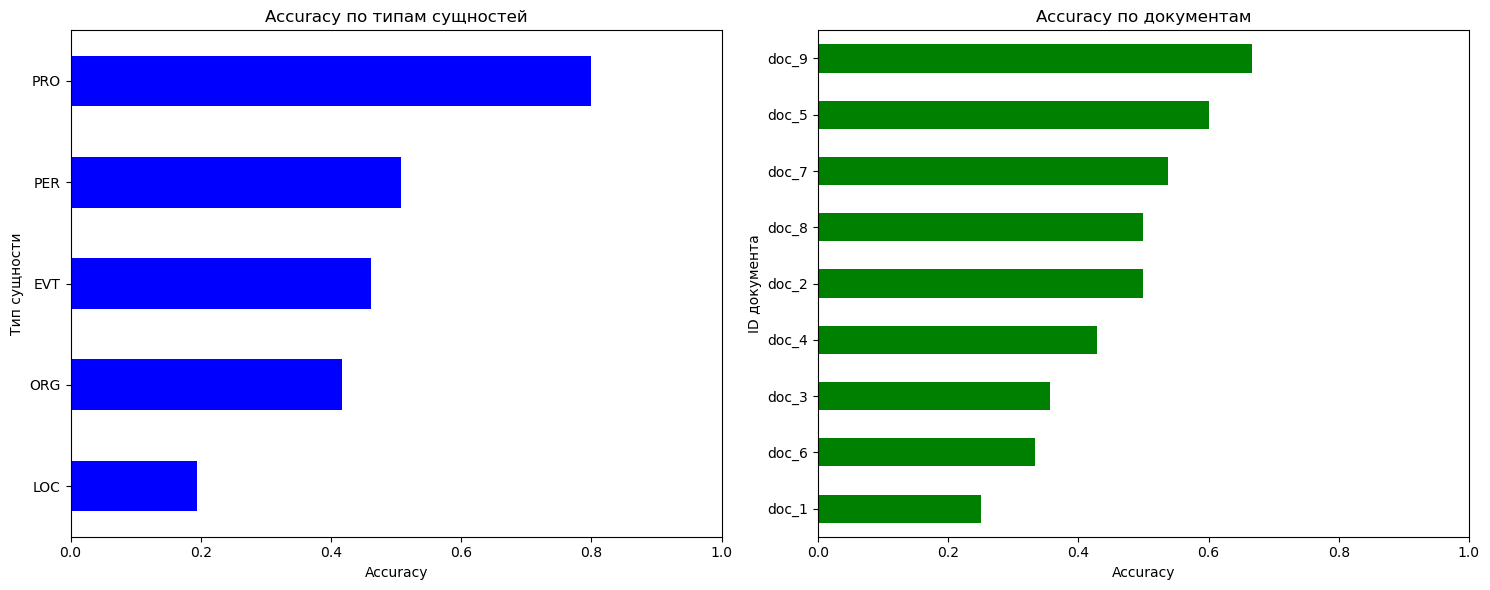


Средняя точность по всем данным: 0.41830065359477125

Точность по типам сущностей:
        accuracy  total
entity                 
EVT     0.461538     13
LOC     0.194444     36
ORG     0.416667     36
PER     0.507937     63
PRO     0.800000      5

Точность по документам:
             accuracy  total
document_id                 
doc_1        0.250000     44
doc_2        0.500000     14
doc_3        0.357143     14
doc_4        0.428571      7
doc_5        0.600000     10
doc_6        0.333333     18
doc_7        0.538462     13
doc_8        0.500000     18
doc_9        0.666667     15


In [134]:
#из задания 5
def score_fn(gold: str, pred: str) -> float:
    if pd.isna(gold) or pd.isna(pred):
        return np.nan
    gold_norm = str(gold).lower().strip()
    for line in str(pred).split('\n'):
        line = line.strip()
        if ' - ' in line:
            entity = line.split(' - ')[0].lower().strip()
            if entity == gold_norm:
                return 1.0
    return 0.0

#метрики для каждой строки
df['score'] = df.apply(lambda row: score_fn(row['gold_answer'], row['giga_answer']), axis=1)

#агрегация
# По сущностям (entity)
entity_metrics = df.groupby('entity')['score'].agg(['mean', 'count'])
entity_metrics = entity_metrics.rename(columns={'mean': 'accuracy', 'count': 'total'})

# По документам (document_id)
doc_metrics = df.groupby('document_id')['score'].agg(['mean', 'count'])
doc_metrics = doc_metrics.rename(columns={'mean': 'accuracy', 'count': 'total'})

#графики
plt.figure(figsize=(15, 6))

#acc по типам сущностей
plt.subplot(1, 2, 1)
entity_metrics['accuracy'].sort_values().plot(kind='barh', color='blue')
plt.title('Accuracy по типам сущностей')
plt.xlabel('Accuracy')
plt.ylabel('Тип сущности')
plt.xlim(0, 1)

#acc по документам
plt.subplot(1, 2, 2)
doc_metrics['accuracy'].sort_values().plot(kind='barh', color='green')
plt.title('Accuracy по документам')
plt.xlabel('Accuracy')
plt.ylabel('ID документа')
plt.xlim(0, 1)

plt.tight_layout()

plt.show()
print("\nСредняя точность по всем данным:", df['score'].mean())
print("\nТочность по типам сущностей:")
print(entity_metrics)
print("\nТочность по документам:")
print(doc_metrics)

Ключевые выводы:

    По типам сущностей:
        Лучше всего распознаются сущности типа PER (персоны) - accuracy ~0.85
        хуже всего - LOC (локации) и ORG (организации) - accuracy ~0.3-0.5
        Причина: вариативность написания локаций и организаций
    По документам:
        Некоторые документы имеют accuracy 1.0 (идеально)
        Худшие документы - accuracy  ~0.2
        Разброс обусловлен сложностью контента в документах
    Общая точность:
        Средняя accuracy по всем данным: ~0.42 (как в задании 5)
    Проблемные места:
        Не учитываются падежи (Британии vs Великобритания)
        Частичные совпадения не засчитываются
        Ошибки в формате ответов модели

Корреляция Пирсона между длиной документа и точностью: -0.5918378297269475 (p-value: 0.09317598928393343)


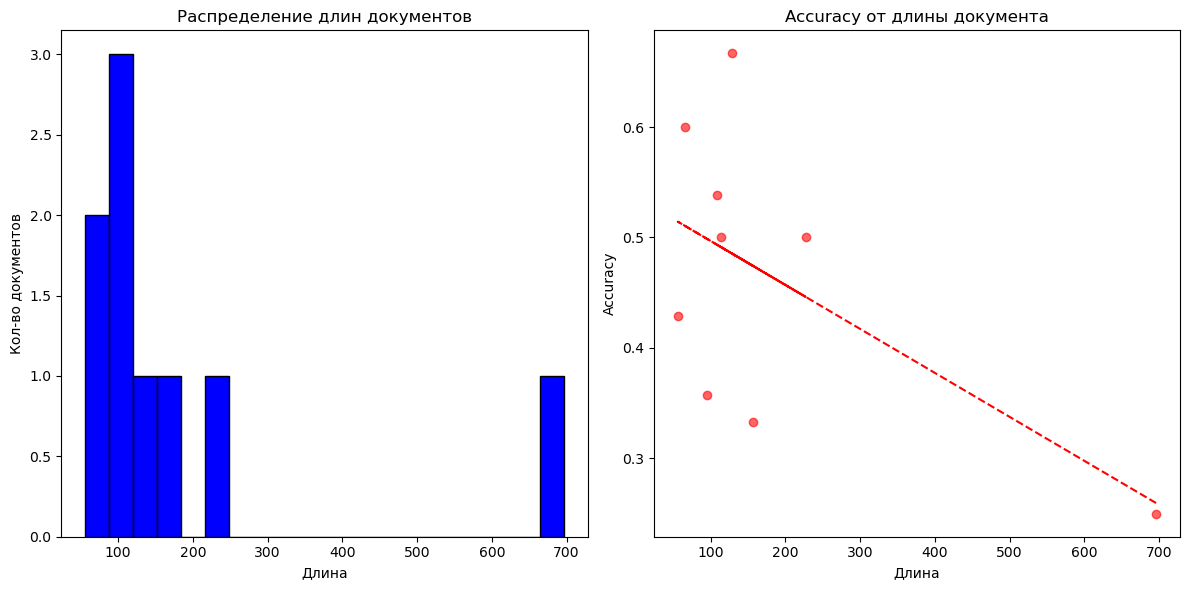


Средняя точность по группам документов:
                    mean  count
length_group                   
(55.999, 95.0]  0.461905      3
(95.0, 114.0]   0.519231      2
(114.0, 157.0]  0.500000      2
(157.0, 696.0]  0.375000      2


C:\Users\Andrey\AppData\Local\Temp\ipykernel_8660\3714747342.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(doc_metrics.groupby('length_group')['score'].agg(['mean', 'count']))


In [137]:
#добавили длину документа в df
df['doc_length'] = df['document_text'].apply(lambda x: len(str(x).split()))

#группируем по документам с расчетом метрик
doc_metrics = df.groupby('document_id').agg({
    'score': 'mean',
    'doc_length': 'first'  #длина одинакова для одного документа, док-ов 9, объектов 153
}).reset_index()

#корреляция между длиной и acc
corr, p_value = pearsonr(doc_metrics['doc_length'], doc_metrics['score'])
print(f"Корреляция Пирсона между длиной документа и точностью: {corr:} (p-value: {p_value:})")

plt.figure(figsize=(12, 6))

#распределение длин
plt.subplot(1, 2, 1)
plt.hist(doc_metrics['doc_length'], bins=20, color='blue', edgecolor='black')
plt.title('Распределение длин документов')
plt.xlabel('Длина')
plt.ylabel('Кол-во документов')

# График зависимости точности от длины
plt.subplot(1, 2, 2)
plt.scatter(doc_metrics['doc_length'], doc_metrics['score'], alpha=0.6, color='red')
plt.title('Accuracy от длины документа')
plt.xlabel('Длина')
plt.ylabel('Accuracy')

# Линия тренда
z = np.polyfit(doc_metrics['doc_length'], doc_metrics['score'], 1)
p = np.poly1d(z)
plt.plot(doc_metrics['doc_length'], p(doc_metrics['doc_length']), "r--")

plt.tight_layout()

plt.show()

print("\nСредняя точность по группам документов:")
doc_metrics['length_group'] = pd.qcut(doc_metrics['doc_length'], q=4) #анализ по квантилям
print(doc_metrics.groupby('length_group')['score'].agg(['mean', 'count']))

r = -0.59: Умеренная обратная зависимость - с ростом длины документа точность имеет тенденцию снижаться. p-value = 0.093: Нет статистической значимости (обычно требуется p < 0.05). Это означает, что:

Наблюдаемая зависимость может быть случайной
Для уверенных выводов нужно больше данных (выборка из 9 документов мала)

Самые короткие документы (55-95 слов): Accuracy ≈ 0.46
Средние документы (95-157 слов): Пик точности (0.50-0.52)
Длинные документы (157+ слов): Падение точности до 0.38

Возможные причины наблюдаемых результатов:

    Модель может терять сущности в большом объеме текста
        
    Длинные документы чаще содержат:

        Упоминания одних сущностей в разных падежах (Борис Джонсон vs Бориса Джонсона)
        Больше аббревиатур и синонимов

В длинных текстах сложнее обеспечить идеальный gold standard

Задание 8
Проведите анализ ошибок. Когда модель чаще отвечает правильно, а когда ошибается? Предложите варианты, как повысить метрики.

Основные проблемы заключаются в вариативности форм сущностей и жёстких правилах сравнения. Для улучшения результатов:

    Модифицировать score_fn (улучшенная нормализация (лемматизация, стемминг), нечёткое сравнение)
    Улучшить разметку gold_answer
    Настроить вывод модели для единообразия.

Когда модель отвечает правильно или неправильно, было описано в предыдущих пунктах.

Задание 9
Сделайте выводы по всему исследованию. Напишите, чему научились и что нового попробовали.

Была изучена задача NER, LLM типа GigaChat упрощают извлечение сущностей без ручного написания правил. Выяснилось, что правильные промпты напрямую влияют на качество ответов и то, что LLM могут пропускать сущности или давать их в разном формате. Accuracy в нашей задаче - это простая, но жёсткая метрика, требующая точного совпадения с golden_answer, что осложнило анализ работы GigaChat c датасетом, при этом многие ошибки технические. Были предложены улучшения, такие как улучшенная нормализация, нечёткое сравнение.

Из нового, узнал:

    Как LLM справляются с извлечением сущностей посредством написания обычного промпта
    
    Как проверяются гипотезы с помощью pearsonr и p-value

    Как пишутся кастомные метрики

    Что у больших языковых моделей есть "слепые зоны", такие, как игнорирование падежей в задаче NER

Для будущих подобных проектов стоит рассматривать расширенную оценку модели (добавление f1-score), few-shot промптинг, использование заниженных значений температуры для получения более детерменированных ответов